In [ ]:
import tsai
from tsai.all import *
import numpy as np

In [ ]:
X = np.load("segments-8.npy")
y = np.load("label-8.npy")
label_names = np.load("label-names-8.npy")

X = np.swapaxes(X, 1, 2) # TODO: double check if this transform is correct!

In [ ]:
decoded_y = np.argmax(y, axis=1)
decoded_y

array([6, 6, 6, ..., 5, 5, 5], dtype=int64)

In [ ]:
y_as_strings = list(map(lambda y : label_names[y], decoded_y)) # inlining did not work?
y = np.array(y_as_strings)

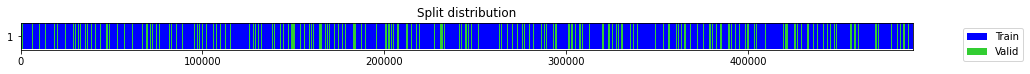

((#392796) [149132,5940,283504,191829,67209,273965,482897,165664,229724,63013...],
 (#98199) [351574,95820,19392,316175,335568,387537,13750,143752,111719,373807...])

In [ ]:
splits = get_splits(y, valid_size=.2, stratify=True, random_state=23, shuffle=True)
splits

In [ ]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#490995) [(TSTensor(vars:20, len:8), TensorCategory(6, dtype=torch.int32)),(TSTensor(vars:20, len:8), TensorCategory(6, dtype=torch.int32)),(TSTensor(vars:20, len:8), TensorCategory(6, dtype=torch.int32)),(TSTensor(vars:20, len:8), TensorCategory(6, dtype=torch.int32)),(TSTensor(vars:20, len:8), TensorCategory(6, dtype=torch.int32)),(TSTensor(vars:20, len:8), TensorCategory(6, dtype=torch.int32)),(TSTensor(vars:20, len:8), TensorCategory(6, dtype=torch.int32)),(TSTensor(vars:20, len:8), TensorCategory(6, dtype=torch.int32)),(TSTensor(vars:20, len:8), TensorCategory(6, dtype=torch.int32)),(TSTensor(vars:20, len:8), TensorCategory(6, dtype=torch.int32))...]

In [ ]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)

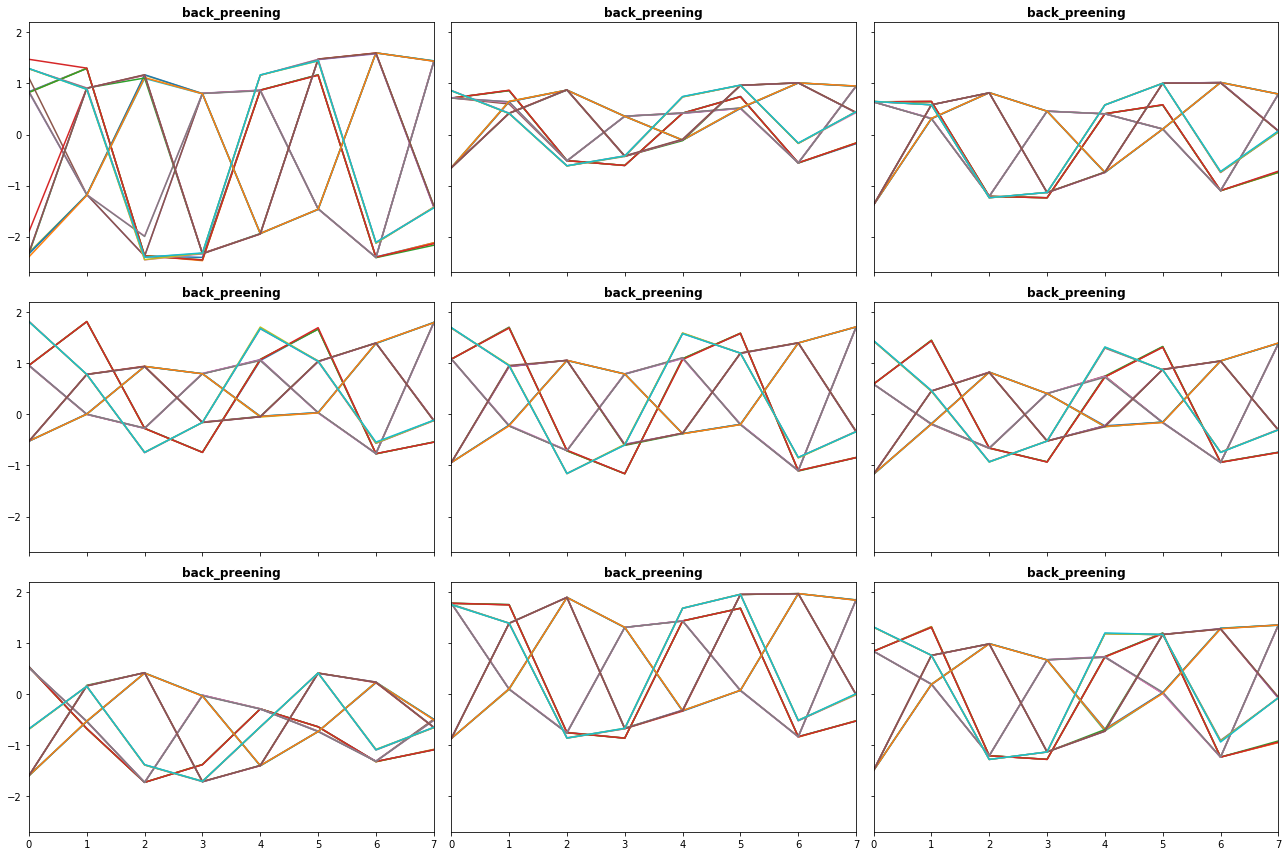

In [ ]:
dls.show_batch(sharey=True)

In [ ]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.save('stage0')

Path('models/stage0.pth')

c:\users\kevin\.virtualenvs\winkie-tu0wptfo\lib\site-packages\fastai\learner.py:55: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


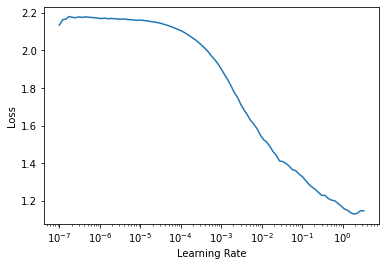

In [ ]:
learn.load('stage0')
learn.lr_find(suggestions=False)

In [ ]:
learn.fit_one_cycle(25, lr_max=1e-3)
learn.save('stage1')

epoch,train_loss,valid_loss,accuracy,time
0,0.124157,0.150144,0.957199,02:12
1,0.107036,0.109140,0.965804,02:16
2,0.095649,0.122105,0.964144,02:27
3,0.084229,0.088885,0.971324,02:21
4,0.064642,0.084749,0.971985,02:27
5,0.048883,0.056433,0.980998,02:18
6,0.053336,0.038791,0.986904,02:15
7,0.040772,0.068373,0.979093,02:24
8,0.032660,0.029291,0.990876,02:14
9,0.025321,0.023546,0.992230,02:10


Path('models/stage1.pth')

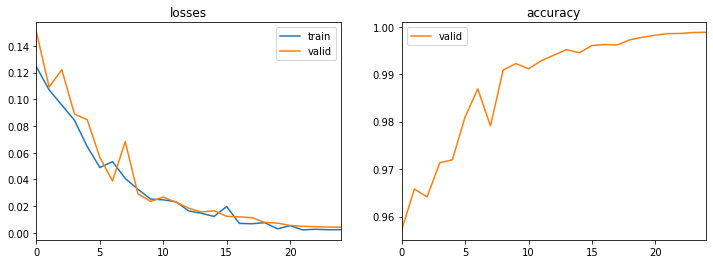

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')

In [ ]:
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
valid_probas, valid_targets, valid_preds

(tensor([[9.8438e-08, 1.0000e+00, 4.5186e-10,  ..., 3.7123e-13, 2.1093e-08,
          6.5945e-12],
         [9.4974e-12, 1.0000e+00, 2.0899e-14,  ..., 1.3665e-11, 1.6185e-08,
          5.5453e-11],
         [5.2036e-09, 1.0000e+00, 1.3365e-12,  ..., 3.0719e-11, 1.7390e-10,
          4.0436e-10],
         ...,
         [9.4582e-13, 1.0000e+00, 1.0908e-16,  ..., 1.6759e-15, 1.2553e-12,
          2.1918e-14],
         [2.9582e-08, 1.0000e+00, 1.0388e-12,  ..., 7.5937e-07, 2.5537e-07,
          7.3620e-08],
         [2.0695e-10, 1.0000e+00, 1.0902e-12,  ..., 1.5886e-09, 8.0207e-10,
          9.0666e-10]]),
 TensorCategory([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 tensor([1, 1, 1,  ..., 1, 1, 1]))

In [ ]:
(valid_targets == valid_preds).float().mean()

TensorCategory(0.9988)

In [ ]:
learn.show_results()

IndexError: list index out of range

<Figure size 1080x1080 with 0 Axes>

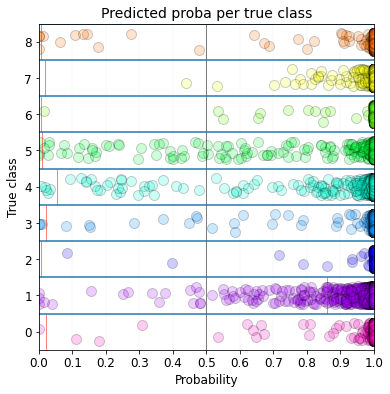

In [ ]:
fig = plt.gcf()
learn.show_probas()
fig.savefig('pred.png')

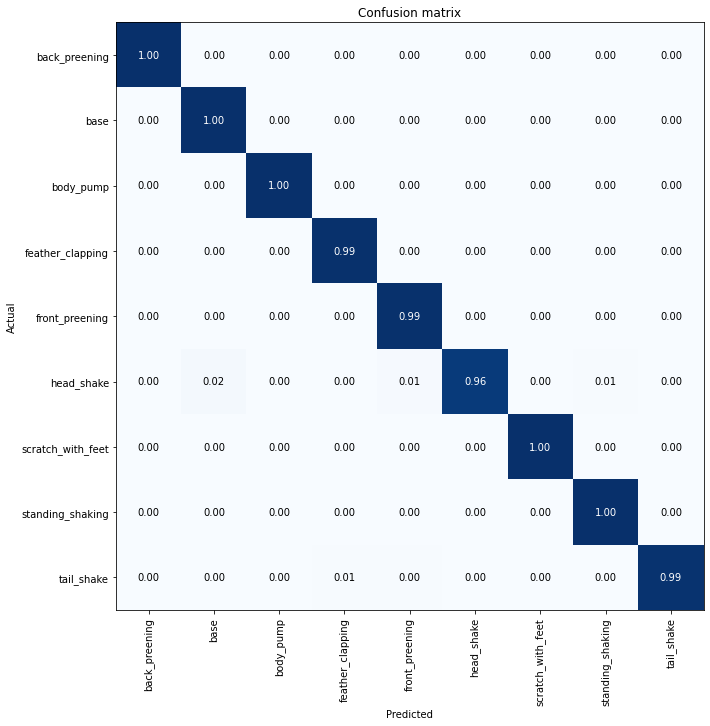

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True, figsize=(10, 10))
plt.savefig('conf_norm.png')

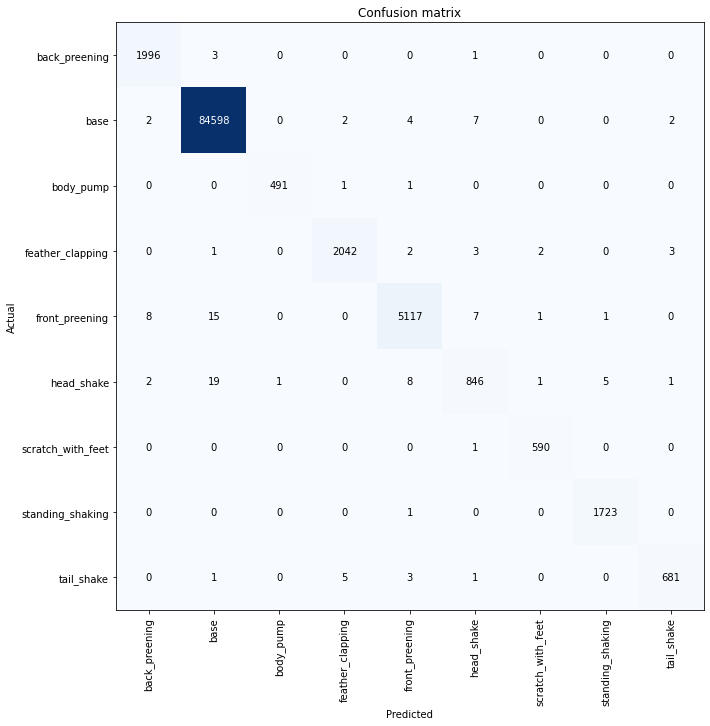

In [ ]:
interp.plot_confusion_matrix(figsize=(10, 10))
plt.savefig('conf_abs.png')

In [ ]:
interp.most_confused(min_val=3)

[('head_shake', 'base', 19),
 ('front_preening', 'base', 15),
 ('front_preening', 'back_preening', 8),
 ('head_shake', 'front_preening', 8),
 ('base', 'head_shake', 7),
 ('front_preening', 'head_shake', 7),
 ('head_shake', 'standing_shaking', 5),
 ('tail_shake', 'feather_clapping', 5),
 ('base', 'front_preening', 4),
 ('back_preening', 'base', 3),
 ('feather_clapping', 'head_shake', 3),
 ('feather_clapping', 'tail_shake', 3),
 ('tail_shake', 'front_preening', 3)]